# Final_model

## Pakiety

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

## Funkcje pomocnicze

In [26]:
def score_kmeans(df, cluster_num_vector):
    """
    Funkcja zwraca miary wcss odpowiadające wartością k,
    działa dla modelu k-średnich.
    """
    scores = []
    for k in cluster_num_vector:
        md = KMeans(n_clusters = k)
        md.fit(df)
        scr = md.score(df)
        scores.append(-scr)
    return(scores)

def find_best_k(df, k_vec):
    scr = score_kmeans(df, k_vec)
    plot_k_scores(k_vec, scr, "k", "wcss", "Metoda łokcia")
    
    
def plot_scor(df,metric,title):
    scors = []
    for k in range(3,8):
        kmean = KMeans(k)
        label = kmean.fit_predict(df)
        scor = metric(df,label)
        scors.append(scor)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(3, 8), scors,marker='h')
    plt.xticks(np.arange(3,8,1))
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Number of clusters')

    

## Wczytanie danych

In [5]:

labels = pd.read_fwf("./UCI_HAR_Dataset/features.txt",header=None)
X_train = pd.read_fwf("./UCI_HAR_Dataset/train/X_train.txt",header=None)
X_train.columns = labels


y_train = pd.read_fwf("./UCI_HAR_Dataset/train/y_train.txt",header=None)
y_train = pd.Series(y_train[0])

X_test = pd.read_fwf("./UCI_HAR_Dataset/test/X_test.txt",header=None)
X_test.columns = labels

y_test = pd.read_fwf("./UCI_HAR_Dataset/test/y_test.txt",header=None)
y_test = pd.Series(y_test[0])

data = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])


In [6]:
proper = list()
for i in range(len(data.columns)):
    proper.append(data.columns[i][0])  
data.columns = proper

data.reset_index(inplace=True,drop=True)

## Wnioski z poprzednich checkpointów

Poprzednio udało się nam sprawdzić, iż do naszego problemu najlepiej pasuje użycie PCA w celu zmniejszenia wymiarowości danych. Teraz zajmiemy się odpowiednim doborem modelu oraz jego parametrów. 

### PCA

In [18]:
pca = PCA(n_components=11)
df_pca = pca.fit_transform(data)

## Dobór ilości klastrów

Aby móc pracować większość algorytmów klasteryzacji wymaga jasno określonej ilości klastrów. Aby ostatecznie zdecydować ile klastrów będzie najlepsze dla naszego problemu zdecydowaliśmy się użyć metody łokcia,metody silhouette oraz metody Calińskiego-Harabasza.

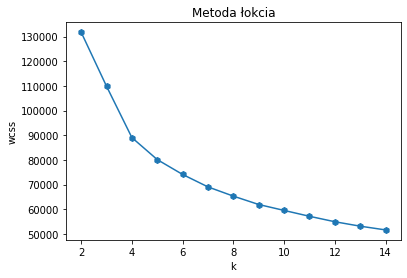

In [29]:
find_best_k(df_pca,range(2,15))

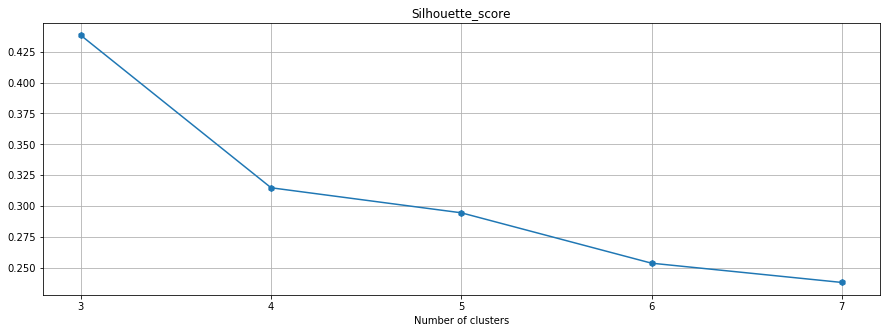

In [31]:
plot_scor(df_pca,silhouette_score,'Silhouette_score')

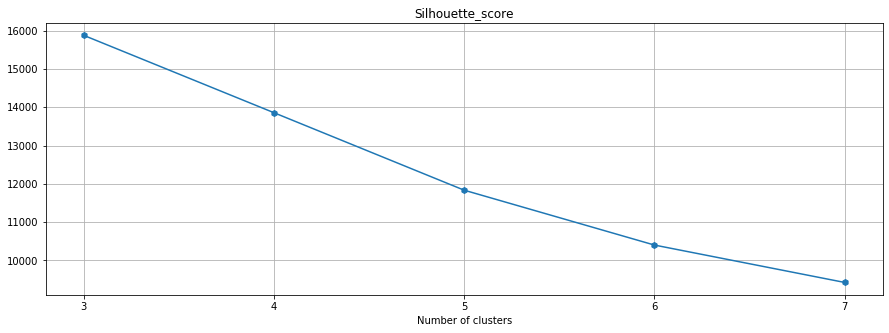

In [33]:
plot_scor(df_pca,calinski_harabasz_score,'Silhouette_score')

Bardzo ciężko o jednoznaczny wybór odpowiedniej ilości klastrów, ale zdecydowaliśmy się wybrać k = 3

## Modelowanie

W celi uzyskania jak najlepszych wyników użyjemy trzech różnych modeli. W trakcie inżynierii cech lepsze wyniki dawało działanie na 3 klastrach, jako że algorytmom łatwiej było podzielić aktywności na te wymagające dużo ruchu oraz bardziej statyczne. Aby sprobówać poprawić wyniki zdecydowaliśmy się zastąpić poprzednio używany algorytm Birch na algorytm DBSCAN.Skorzystamy więc z:
- KMeans
- DBSCAN
- AgglomerativeClustering

Warto będzie zwrócić uwagę na sprawowanie się algorytmu DBSCAN, z racji tego że cechuje się on innym działaniem niż pozostałę dwa, tzn. nie wymaga dokładnej ilości klastrów do pracy.


In [35]:
kmean = KMeans(3)
labels_kmean = kmean.fit_predict(df_pca)

In [36]:
agg = AgglomerativeClustering(3)
labels_agg = agg.fit_predict(df_pca)

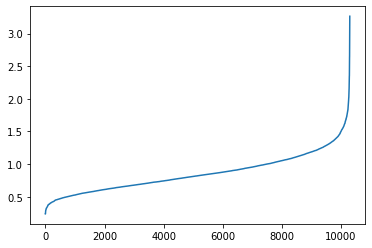

In [74]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


Aby dobrać odpowiedni parametr eps dla algorytmu DBSCAN użyjemy metody opisanej w: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
        Mówiąc ogólnie, znajdujemy odpowiednią wartość dla  epsilona, obliczając odległość do najbliższych n punktów dla każdego punktu, sortując i rysując wyniki. Następnie sprawdzamy, gdzie wzrost jest jak największy (podobnie jak w metodzie łokcia).
Z wykresu najlepiej to wygląda dla eps=1.5.

In [103]:
for i in range(1,20):
    dbs = DBSCAN(1.5,i)
    labels_dbs = dbs.fit_predict(df_pca)
    score = silhouette_score(df_pca,labels_dbs)
    print(f'Ilość sąsiadów = {i}, wynik = {round(score,2)}')

Ilość sąsiadów = 1, wynik = -0.4
Ilość sąsiadów = 2, wynik = -0.2
Ilość sąsiadów = 3, wynik = -0.08
Ilość sąsiadów = 4, wynik = 0.02
Ilość sąsiadów = 5, wynik = 0.06
Ilość sąsiadów = 6, wynik = 0.31
Ilość sąsiadów = 7, wynik = 0.38
Ilość sąsiadów = 8, wynik = 0.25
Ilość sąsiadów = 9, wynik = 0.3
Ilość sąsiadów = 10, wynik = 0.27
Ilość sąsiadów = 11, wynik = 0.31
Ilość sąsiadów = 12, wynik = 0.32
Ilość sąsiadów = 13, wynik = 0.29
Ilość sąsiadów = 14, wynik = 0.41
Ilość sąsiadów = 15, wynik = 0.41
Ilość sąsiadów = 16, wynik = 0.31
Ilość sąsiadów = 17, wynik = 0.26
Ilość sąsiadów = 18, wynik = 0.26
Ilość sąsiadów = 19, wynik = 0.24


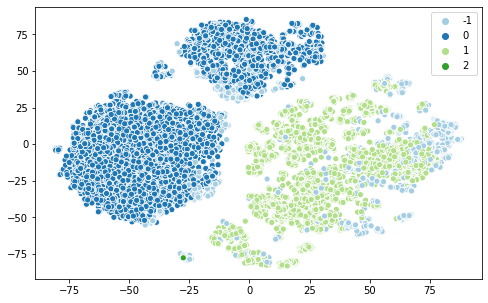

In [104]:
dbs = DBSCAN(1.5,14)
labels_dbs = dbs.fit_predict(df_pca)
score = silhouette_score(df_pca,labels_dbs)

pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_data)

fig = plt.gcf()
fig.set_size_inches(8,5)
sns.scatterplot(tsne_transformed[:,0],tsne_transformed[:,1],hue=labels_dbs,palette='Paired')

Klastry zaproponowane przez DBSCAN wyglądają średnio sensownie.